In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold


In [2]:

# df_TagDesc = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\CSV\Not for Processing\TagDesc.csv')

# df_All_1 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_1o2.csv')
# df_All_2 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_2o2.csv')
# # Concatenate (union) the dataframes
# df_All = pd.concat([df_All_1, df_All_2], ignore_index=True)

df_All = pd.read_csv(r'C:\Users\austinsh\Project-OptiC4\III Models\3 Model STEAM - FC55569\3 Feature Selection\filtered-out_5-9_corr.csv')

print(df_All.head())


                  Date  425_pct_Al     Al2O3  M_Value  C4_pct_Eth  C4_pct_H2O  \
0  2012-05-17 09:00:00    6.319560  11.41670  3.50773    2.554580     22.0531   
1  2012-05-17 10:00:00    6.319915  11.40835  3.50797    2.555935     22.0557   
2  2012-05-17 12:00:00    6.320970  11.39165  3.50869    2.560005     22.0636   
3  2012-05-18 08:00:00    6.328690  11.39165  3.51401    2.540370     22.0604   
4  2012-05-18 09:00:00    6.336060  11.40500  3.51910    2.514430     22.0484   

   HydWtr_pct_Ammonia  C4_pct_Hex  HydWtr_Na2O  Butanol  ...   LC55557  \
0            0.867508    0.670721     3.354160  30.3662  ...  66.31395   
1            0.864729    0.671059     3.306475  30.3662  ...  66.31395   
2            0.856391    0.672071     3.163420  30.6785  ...  66.31395   
3            0.811652    0.674174     2.238130  32.6454  ...  65.92560   
4            0.773793    0.675408     1.391475  32.6454  ...  65.92560   

    LC55568    LC90366   LC90368   PI55004   PI55020   TC55552   TC5

In [3]:
# Set max columns to display
pd.set_option('display.max_columns', None)

In [4]:
# # List of columns to exclude from the XGboost feature selection results
exclude_columns = [
                    'M_Value',
                    'HydWtr_pct_Ammonia',
                    'HydWtr_Na2O',

                    'PI55004',
                    'Decanol',
                    'LC55557',
                    'LC52572',
                    'LC55568',
                    'LC90368',
                    'LC55553',

                    'TC55552',
                    'FC55009',
                    'TC55555',
                    'FC55552',

                    'FFC55553', # Reiterating within this run, since it was the only one found.

                    # Should have processed these out earlier, but was assuming some Butanol as an adjuster
                    # # FFC55555 is s better predicter according to the XGB-FS
                    'Butanol',
                    'TI55021',
                    'TI40050'

#                  'Date',
#                  'C4_pct_Hex', 'HydWtr_Na2O',
#                  'TC55555'  
                   ]

# # Create a new DataFrame without the excluded columnsd
df_All = df_All.drop(columns=exclude_columns)

In [5]:
df_All.columns

Index(['Date', '425_pct_Al', 'Al2O3', 'C4_pct_Eth', 'C4_pct_H2O', 'C4_pct_Hex',
       'DI55102', 'DI55152', 'DI55580', 'FC55003', 'FC55569', 'FC55576',
       'FFC55555', 'LC90366', 'PI55020'],
      dtype='object')

In [6]:
# df_All = df_All[df_All['Date'] > '2020-06-15 00:00:00']

In [7]:
# df_All.drop('Date', axis=1, inplace=True)




In [8]:
print(df_All.describe())

         425_pct_Al         Al2O3    C4_pct_Eth    C4_pct_H2O    C4_pct_Hex  \
count  40127.000000  40127.000000  40127.000000  40127.000000  40127.000000   
mean       6.133716     11.382607      1.213887     21.178645      0.471411   
std        0.228800      0.547831      0.691779      2.750323      0.241196   
min        5.270185      9.740945      0.030786      7.714985      0.000327   
25%        6.003510     11.095875      0.621701     18.843125      0.353947   
50%        6.135865     11.495850      1.103350     21.462900      0.447077   
75%        6.265830     11.719825      1.687807     23.275925      0.546428   
max        7.026215     12.879900      9.466675     34.151950      3.075880   

            DI55102       DI55152       DI55580       FC55003       FC55569  \
count  40127.000000  40127.000000  40127.000000  40127.000000  40127.000000   
mean       0.944657      0.932500      0.995820   5994.093426   6599.626128   
std        0.051564      0.028840      0.045932    

In [9]:
# Assuming your data is in filtered_df and you want to predict 'target_column_name'
X = df_All.drop(['FC55569', 'Date'], axis=1)  # Replace 'target_column_name' with your target column's name
y = df_All['FC55569']

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    learning_rate=0.05,
    n_estimators=800,
    max_depth=10,
    subsample=0.6,
    colsample_bytree=1,
    gamma=0,
    alpha=0.1,
    reg_lambda=1.5,
    colsample_bylevel=0.8,
    colsample_bynode=0.7
)
xgb_model.fit(X_train, y_train)

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=0.7, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
# Predict on training data
y_train_pred = xgb_model.predict(X_train)

# Evaluate the model on training data
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error on Training Data: {mse_train}")



# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Testing Data: {mse}")

rmse_train = np.sqrt(mse_train)
print(f"Root Mean Squared Error on Training Data: {rmse_train}")


rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on the Testing Data: {rmse}")

# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
print(f"R-squared value on Training Data:: {r2_train:.2f}")


# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared value on the Testing Data: {r2:.2f}")

current_features = X.columns.tolist()

# Calculate Adjusted R-squared
def adjusted_r2(r2, n, k):
    """
    Compute the adjusted R^2 from R^2, number of samples (n) and number of predictors (k).
    
    Args:
    - r2 (float): R^2 value
    - n (int): number of samples
    - k (int): number of predictors

    Returns:
    - float: adjusted R^2 value
    """
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)


adj_r2 = adjusted_r2(r2, len(y_test), len(current_features))

print(f"Adjusted R^2 value: {adj_r2}")

Mean Squared Error on Training Data: 14.301522112578246
Mean Squared Error on the Testing Data: 264.49924004523217
Root Mean Squared Error on Training Data: 3.781735330847235
Root Mean Squared Error on the Testing Data: 16.263432603396865
R-squared value on Training Data:: 1.00
R-squared value on the Testing Data: 1.00
Adjusted R^2 value: 0.9979879338193313


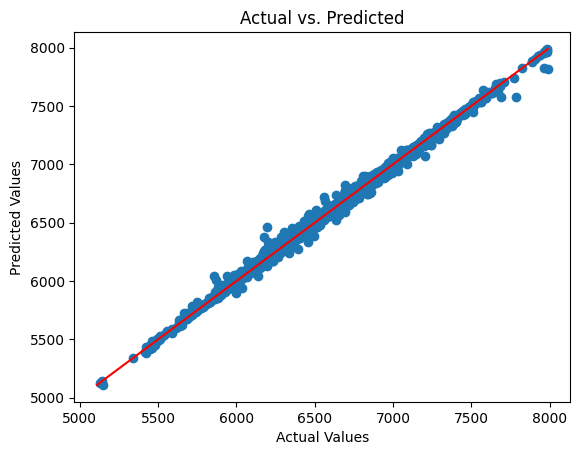

In [13]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')

# Calculate the min and max values across both y_test and y_pred
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))

# Plot the red 1:1 line
plt.plot([min_val, max_val], [min_val, max_val], color='red')  # 1:1 line

plt.show()


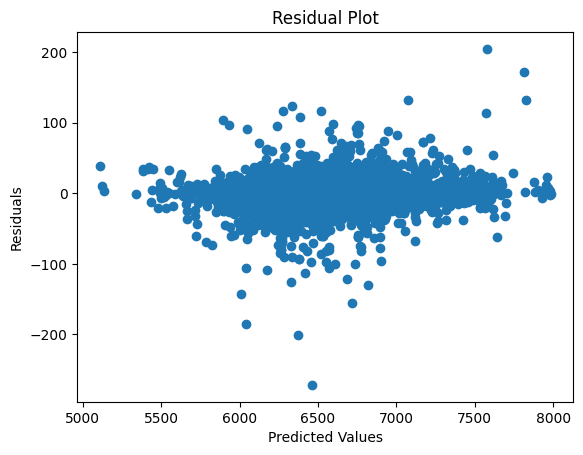

In [14]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [15]:
num_rows = df_All.shape[0]

splits = num_rows//10000

if splits < 5:
    splits = 5

In [16]:
# Define the K-fold cross validator
kfold = KFold(n_splits=splits, shuffle=True, random_state=42)

# Perform K-fold cross-validation
scores = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

# Take the square root of the scores to get the RMSE
rmse_scores = np.sqrt(-scores)

# Print out the results
print(f'Scores for each fold are: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Standard deviation of RMSE: {np.std(rmse_scores)}')

Scores for each fold are: [20.26822555 21.00845288 22.89223787 21.90791822 23.35126947]
Average RMSE: 21.885620796644027
Standard deviation of RMSE: 1.1443156966988193


In [17]:
df_All.columns

Index(['Date', '425_pct_Al', 'Al2O3', 'C4_pct_Eth', 'C4_pct_H2O', 'C4_pct_Hex',
       'DI55102', 'DI55152', 'DI55580', 'FC55003', 'FC55569', 'FC55576',
       'FFC55555', 'LC90366', 'PI55020'],
      dtype='object')